In [ ]:
# standard ds imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for statistical analysis
import scipy.stats as stats

# for wrangling
import wrangle
import explore

# for scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

# for feature selection verification and evaluation 
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

#### 1. Select a dataset with a continuous target variable.

In [2]:
zil = wrangle.wrangle_zillow()

#### 2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

In [3]:
train, val, test = wrangle.split_data(zil)

In [4]:
train, val, test = wrangle.impute_mode(train, val, test, 'built')

In [6]:
train = wrangle.feature_engineer(train)
val = wrangle.feature_engineer(val)
test = wrangle.feature_engineer(test)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1113171 entries, 759032 to 843328
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   beds                 1113171 non-null  float64
 1   baths                1113171 non-null  float64
 2   sqft                 1113171 non-null  float64
 3   tax_value            1113171 non-null  float64
 4   built                1113171 non-null  float64
 5   taxes                1113171 non-null  float64
 6   location             1113171 non-null  object 
 7   los_angeles          1113171 non-null  int64  
 8   orange               1113171 non-null  int64  
 9   ventura              1113171 non-null  int64  
 10  decade               1113171 non-null  int64  
 11  location_percentile  1113171 non-null  int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 110.4+ MB


In [8]:
cols = train.drop(columns=['location', 'tax_value']).columns.tolist()

In [9]:
train_scaled, val_scaled, test_scaled = wrangle.scale_data(train, val, test, cols)

In [10]:
X_train = train_scaled.drop(columns=['location', 'tax_value'])
X_val = val_scaled.drop(columns=['location', 'tax_value'])
X_test = test_scaled.drop(columns=['location', 'tax_value'])

In [11]:
y_train = train.tax_value
y_val = val.tax_value
y_test = test.tax_value

In [12]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1113171, 10), (1113171,), (371057, 10), (371057,), (371057, 10), (371057,))

#### 3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

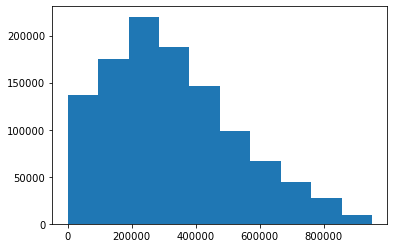

In [13]:
plt.hist(y_train)
plt.show()

#### BASELINE

In [14]:
y_train.mean()

327901.2780588068

In [15]:
y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)
y_test = pd.DataFrame(y_test)

In [16]:
pred_mean = y_train.tax_value.mean()
y_train['pred_mean'] = pred_mean
y_val['pred_mean'] = pred_mean

pred_median = y_train.tax_value.median()
y_train['pred_median'] = pred_median
y_val['pred_median'] = pred_median

rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_mean, squared=False)
rmse_val = mean_squared_error(y_val.tax_value, y_val.pred_mean, squared=False)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_val, 2))

RMSE using Mean
Train/In-Sample:  198989.99 
Validate/Out-of-Sample:  198650.02


In [17]:
rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_median, squared=False)
rmse_val = mean_squared_error(y_val.tax_value, y_val.pred_median, squared=False)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_val, 2))

RMSE using Median
Train/In-Sample:  201452.99 
Validate/Out-of-Sample:  201084.14


In [18]:
# Mean is a better baseline

In [19]:
metrics = pd.DataFrame(data=[{
    'model': 'baseline_mean',
    'rmse_val': rmse_val,
    'r2_val': explained_variance_score(y_val.tax_value, y_val.pred_mean)}])
metrics

,model,rmse_val,r2_val
0,baseline_mean,201084.138757,0.0


#### OLS

In [20]:
X_train.head()

,beds,baths,sqft,built,taxes,los_angeles,orange,ventura,decade,location_percentile
759032,0.333333,0.333333,0.513347,0.617647,0.180377,1.0,0.0,0.0,0.619048,0.000000
1533668,0.000000,0.000000,0.358756,0.637255,0.366890,1.0,0.0,0.0,0.666667,0.666667
1070151,1.000000,1.000000,0.733353,0.720588,0.554876,1.0,0.0,0.0,0.714286,1.000000
59636,0.000000,0.333333,0.330595,0.828431,0.240337,1.0,0.0,0.0,0.857143,0.333333
17435,0.666667,1.000000,0.954825,0.857843,0.796453,1.0,0.0,0.0,0.857143,1.000000


In [21]:
lm = LinearRegression(normalize=True)
lm.fit(X_train, y_train.tax_value)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


LinearRegression(normalize=True)

In [22]:
y_train['pred_lm'] = lm.predict(X_train)
rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lm, squared=False)
y_val['pred_lm'] = lm.predict(X_val)
rmse_val = mean_squared_error(y_val.tax_value, y_val.pred_lm, squared=False)
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_val)

RMSE for OLS using LinearRegression
Training/In-Sample:  44747.744362888225 
Validation/Out-of-Sample:  45226.35175715886


In [23]:
metrics = metrics.append({
    'model': 'OLS',
    'rmse_val': rmse_val,
    'r2_val': explained_variance_score(y_val.tax_value, y_val.pred_lm)}, ignore_index=True)
metrics

/var/folders/tg/htdzmdmj40vgs24scqz284xm0000gn/T/ipykernel_51268/3355564652.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


,model,rmse_val,r2_val
0,baseline_mean,201084.138757,0.000000
1,OLS,45226.351757,0.948167


#### LassoLars

In [24]:
lars = LassoLars(alpha=1)
lars.fit(X_train, y_train.tax_value)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


LassoLars(alpha=1)

In [25]:
y_train['pred_lars'] = lars.predict(X_train)
rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lars, squared=False)
y_val['pred_lars'] = lars.predict(X_val)
rmse_val = mean_squared_error(y_val.tax_value, y_val.pred_lars, squared=False)
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_val)

RMSE for Lasso + Lars
Training/In-Sample:  44883.67445470185 
Validation/Out-of-Sample:  45359.69995067482


In [26]:
metrics = metrics.append({
    'model': 'LarsLasso, alpha 1',
    'rmse_val': rmse_val,
    'r2_val': explained_variance_score(y_val.tax_value, y_val.pred_lars)}, ignore_index=True)
metrics

/var/folders/tg/htdzmdmj40vgs24scqz284xm0000gn/T/ipykernel_51268/599908125.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


,model,rmse_val,r2_val
0,baseline_mean,201084.138757,0.000000
1,OLS,45226.351757,0.948167
2,"LarsLasso, alpha 1",45359.699951,0.947861


In [41]:
glm = TweedieRegressor(power=1.8, alpha=0)
glm.fit(X_train, y_train.tax_value)

TweedieRegressor(alpha=0, power=1.8)

In [42]:
y_train['pred_glm'] = glm.predict(X_train)
rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_glm, squared=False)
y_val['pred_glm'] = glm.predict(X_val)
rmse_val = mean_squared_error(y_val.tax_value, y_val.pred_glm, squared=False)
print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_val)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  71326.93173905819 
Validation/Out-of-Sample:  71769.1192727566


In [43]:
metrics = metrics.append({
    'model': 'Compound 1.8',
    'rmse_val': rmse_val,
    'r2_val': explained_variance_score(y_val.tax_value, y_val.pred_glm)}, ignore_index=True)
metrics

/var/folders/tg/htdzmdmj40vgs24scqz284xm0000gn/T/ipykernel_51268/3248062047.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


,model,rmse_val,r2_val
0,baseline_mean,201084.138757,0.000000
1,OLS,45226.351757,0.948167
2,"LarsLasso, alpha 1",45359.699951,0.947861
3,Inverse Gaussian,198650.019930,0.000000
4,Gamma,81847.766037,0.832621
5,Poisson,59471.993826,0.910371
6,Compound 1.2,60782.404691,0.906379
7,Compound 1.8,71769.119273,0.870149


#### Polynomial

In [44]:
pf = PolynomialFeatures(degree=4)
X_train_d2 = pf.fit_transform(X_train)
X_val_d2 = pf.transform(X_val)
X_test_d2 = pf.transform(X_test)

In [45]:
X_train_d2.shape, X_val_d2.shape, X_test_d2.shape

((1113171, 1001), (371057, 1001), (371057, 1001))

In [ ]:
lm2 = LinearRegression()
lm2.fit(X_train_d2, y_train.tax_value)

In [ ]:
y_train['pred_lm2'] = lm2.predict(X_train_d2)
rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lm2, squared=False)
y_val['pred_lm2'] = lm2.predict(X_val_d2)
rmse_val = mean_squared_error(y_val.tax_value, y_val.pred_lm2, squared=False)


print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_val)

In [47]:
metrics = metrics.append({
    'model': 'd4',
    'rmse_val': rmse_val,
    'r2_val': explained_variance_score(y_val.tax_value, y_val.pred_lm2)}, ignore_index=True)
metrics

/var/folders/tg/htdzmdmj40vgs24scqz284xm0000gn/T/ipykernel_50806/2330926957.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


,model,rmse_val,r2_val
0,baseline_mean,201084.138757,0.000000
1,OLS,46510.109221,0.945183
2,"LarsLasso, alpha 1",46627.745896,0.944905
3,Inverse Gaussian,198650.019930,0.000000
4,Quadratic,44136.688483,0.950635
5,d4,41855.264371,0.955606


#### Quadratic wins, but is probably overfit

In [34]:
y_test['pred_lm2'] = lm2.predict(X_test_d2)
rmse_test = mean_squared_error(y_test.tax_value, y_test.pred_lm2, squared=False)
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_val,
      "\nTest/Out-of-Sample: ", rmse_test)

RMSE for OLS using LinearRegression
Training/In-Sample:  43667.90085687835 
Validation/Out-of-Sample:  44136.68848277937 
Test/Out-of-Sample:  43710.64610899026


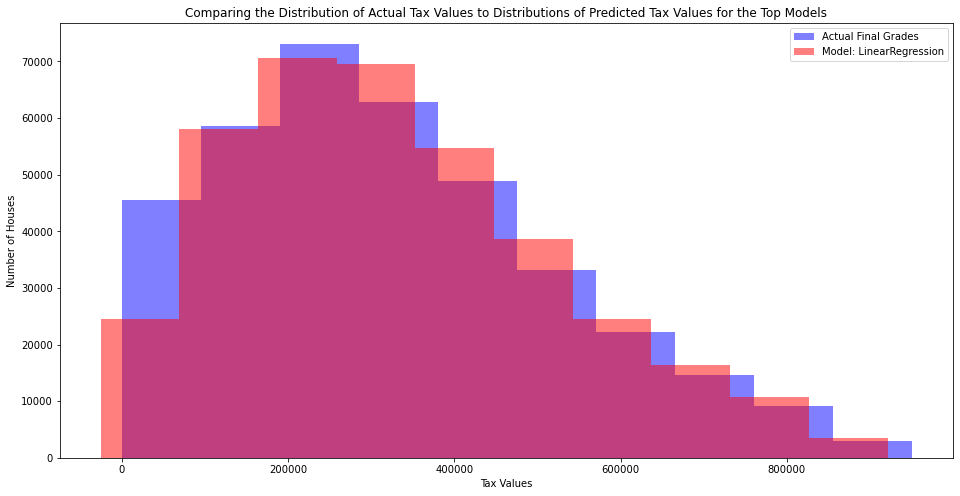

In [38]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_val.tax_value, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_val.pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
# plt.hist(y_val.pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
# plt.hist(y_val.pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Values")
plt.ylabel("Number of Houses")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()